# 한국어 데이터로 챗봇 만들기
---

한국어 데이터로 훈련시키는 챗봇을 만들어보자 ᕕ( ᐛ )ᕗ~♪

## STEP 0. 설계
---

한국어 챗봇을 만들기 위하여 다음과 같은 순서로 프로젝트를 수행한다.
1. 데이터 수집 : 송영숙님이 공개한 챗봇 데이터를 다운로드 받는다.
2. 데이터 전처리
    - 구두점 및 결측치 제거
    - 데이터를 질문/답변의 쌍으로 전처리
    - 단어장 만들기 : `tfds.deprecated.text.SubwordTextEncoder` 사용
    - 정수인코딩 & 패딩
    - 교사 강요
3. 모델 정의 및 학습
    - 모델 정의를 위하여 다음 사항들을 정의한다.
        - PositionalEncoding
        - scaled_dot_product_attention
        - MultiHeadAttention
        - create_padding_mask
        - create_look_ahead_mask
        - encoder_layer : require MultiHeadAttention
        - encoder : require PositionalEncoding, encoder_layer
        - decoder_layer : require MultiHeadAttention
        - decoder : require PositionalEncoding, decoder_layer
    - 모델 정의 및 학습
        - 모델 정의 : transformer
        - 손실함수 정의
        - 커스텀 학습률 스케줄링을 통한 learning rate 정의
        - 모델 컴파일
        - 모델 훈련
4. 모델 평가
    - 질문을 입력받아 챗봇의 대답을 디코딩하여 돌려주는 함수 sentence_generation를 정의
    - 임의의 문장들을 이용하여 챗봇의 성능을 테스트해본다.

#### environment setting
- import packages
- set directory path
- load extensor to measure cell running time
- initialization gpu

In [15]:
# import packages ########################################################
import numpy as np
import os
import re
from os.path import join
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

# set directory path# #######################################################
workspace_path = os.getenv('HOME')+'/workspace/aiffel-exploration-workspace/E15_transformer'
data_dir_path = workspace_path + '/data'

# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## STEP 1. 데이터 수집
---

- 데이터 다운로드

In [8]:
#! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv -P ./data

In [12]:
! ls ./data

ChatbotData.csv


데이터를 성공적으로 다운로드 받았다!

- 데이터 불러오기

In [20]:
raw_data = pd.read_csv(data_dir_path + '/ChatbotData.csv')
raw_data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [18]:
raw_data.shape

(11823, 3)

In [26]:
raw_data[raw_data['label'] == 1][:5]

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [27]:
raw_data[raw_data['label'] == 2][:5]

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


해당 데이터는 질문-대답-라벨의 구성을 가지며, 총 11823 쌍의 데이터가 존재한다.<br>
데이터의 라벨은 0 : 일상다반사, 1 : 이별(부정), 2 : 사랑(긍정)으로 정의되어 있다.

## STEP 2. 데이터 전처리
---

### 1. 구두점 및 결측치 처리

- 결측치 확인

In [19]:
raw_data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

결측치가 없으므로 결측치에 대한 처리는 불필요하다.

- 구두점 처리

In [43]:
def remove_punctuation(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, 가-힣, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

일단 함수를 정의하여 두고, 아래의 단계에서 함께 처리하도록 하자.

### 2. 데이터를 질문/답변의 쌍으로 전처리

입력된 데이터를 전처리하여 questions, answers로 나누어 저장한다.

In [44]:
def get_questions_answers(raw_data):
    questions = [ remove_punctuation(sentence) for sentence in raw_data['Q'].values ]
    answers   = [ remove_punctuation(sentence) for sentence in raw_data['A'].values ]
    return questions, answers

In [82]:
questions, answers = get_questions_answers(raw_data)

- 데이터 확인

In [74]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [75]:
for i in np.random.randint(0, len(questions), 5):
    print(f'전처리 후의 {i+1:-5d}번째 질문 샘플: {questions[i]}')
    print(f'전처리 후의 {i+1:-5d}번째 답변 샘플: {answers[i]}\n')

전처리 후의  8391번째 질문 샘플: 핑계
전처리 후의  8391번째 답변 샘플: 모두 핑계겠죠 .

전처리 후의  7790번째 질문 샘플: 일주일간 괜찮았는데 .
전처리 후의  7790번째 답변 샘플: 갑자기 생각나기도 한답니다 .

전처리 후의  1240번째 질문 샘플: 더우니까 무서운 이야기 듣고싶지
전처리 후의  1240번째 답변 샘플: 해주세요 .

전처리 후의  5864번째 질문 샘플: 내 욕심일 뿐이지
전처리 후의  5864번째 답변 샘플: 사랑인 거예요 .

전처리 후의   641번째 질문 샘플: 나만 제자리인듯
전처리 후의   641번째 답변 샘플: 제자리여도 괜찮아요



### 3. 단어장 만들기 
TensorFlow Datasets SubwordTextEncoder를 사용하여 tokenier를 정의하고, 데이터셋에 대하여 단어장*Vocabulary*를 생성한다.

- tokenizer 정의

In [56]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

- 시작/종료 토큰에 고유한 정수를 부여

In [57]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


- 시작/종료 토큰이 추가 되었으므로 단어장의 크기도 증가시킨다.

In [58]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


### 4. 정수인코딩 & 패딩
tokenizer를 이용하여 단어를 정수로 인코딩한다.

-  인코딩 테스트

In [83]:
# encoding test
print('정수 인코딩 후의 100번째 질문 샘플: {}'.format(tokenizer.encode(questions[100])))
print('정수 인코딩 후의 100번째 답변 샘플: {}'.format(tokenizer.encode(answers[100])))

정수 인코딩 후의 100번째 질문 샘플: [1939, 459]
정수 인코딩 후의 100번째 답변 샘플: [500, 6963, 7938, 689, 2446, 49]


- 패딩을 위한 문장의 최대길이 정의

👉 문장의 평균 길이
질문: 13.213735938425103
답변: 16.035439397783982
👉 문장의 최소 길이
질문: 1
답변: 1
👉 문장의 최대 길이
질문: 57
답변: 78


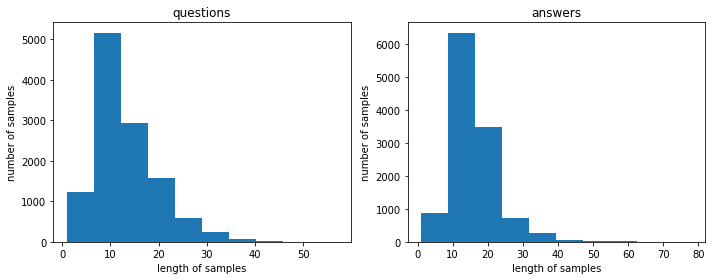

In [77]:
num_questions = np.array([len(s) for s in questions])
num_answers = np.array([len(s) for s in answers])

print(f'👉 문장의 평균 길이')
print(f'질문: {np.mean(num_questions)}')
print(f'답변: {np.mean(num_answers)}')

print(f'👉 문장의 최소 길이')
print(f'질문: {np.min(num_questions)}')
print(f'답변: {np.min(num_answers)}')

print(f'👉 문장의 최대 길이')
print(f'질문: {np.max(num_questions)}')
print(f'답변: {np.max(num_answers)}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(num_questions)
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
ax1.set_title('questions')

ax2.hist(num_answers)
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
ax2.set_title('answers')

plt.tight_layout()
plt.show()

In [84]:
MAX_LENGTH = 20 + 2 # 토큰길이 포함

- 정수 인코딩 + 최대길이 초과 샘플 제거 + 패딩

In [85]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 MAX_LENGTH으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [89]:
questions, answers = tokenize_and_filter(questions, answers)

In [91]:
print('단어장의 크기 :',(VOCAB_SIZE))
print(f'필터링 후의 질문 샘플 개수: {len(questions)}')
print(f'필터링 후의 답변 샘플 개수: {len(answers)}')
print(f'필터링 후의 100번째 질문 샘플: \n{questions[100]}')
print(f'필터링 후의 100번째 답변 샘플: \n{answers[100]}')

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11803
필터링 후의 답변 샘플 개수: 11803
필터링 후의 100번째 질문 샘플: 
[8162 1939  459 8163    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
필터링 후의 100번째 답변 샘플: 
[8162  500 6963 7938  689 2446   49 8163    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### 5. 교사 강요를 적용한 Dataset 생성

In [93]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [94]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 22), dec_inputs: (None, 21)}, {outputs: (None, 21)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## STEP 3. 모델 정의 및 학습
---

### 1. 함수 정의
모델 정의를 위하여 다양항 요소들을 함수로 정의한다.

#### PositionalEncoding

In [95]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
                        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                        d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- function 테스트

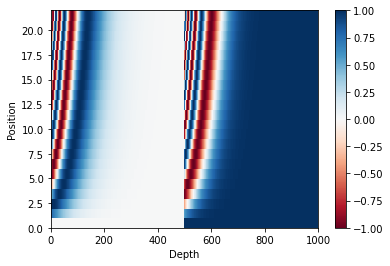

In [100]:
sample_pos_encoding = PositionalEncoding(22, 1000)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 1000))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### scaled_dot_product_attention

In [111]:
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

#### MultiHeadAttention

In [103]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], 
                                  inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

#### create_padding_mask

In [104]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [106]:
create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]]))

<tf.Tensor: shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 0., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

#### create_look_ahead_mask

In [107]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [108]:
create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]]))

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]]], dtype=float32)>

In [109]:
create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]]))

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1.],
         [1., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.]]]], dtype=float32)>

#### encoder_layer 

In [112]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
                  d_model, num_heads, name="attention")({
                      'query': inputs,
                      'key': inputs,
                      'value': inputs,
                      'mask': padding_mask
                  })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### encoder 

In [113]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i))([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### decoder_layer

In [114]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### decoder

In [115]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


### 2. 모델 정의 및 학습

#### 모델 정의 : transformer

In [116]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [117]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실함수 정의

In [118]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 커스텀 학습률 스케줄링을 통한 learning rate 정의

In [119]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

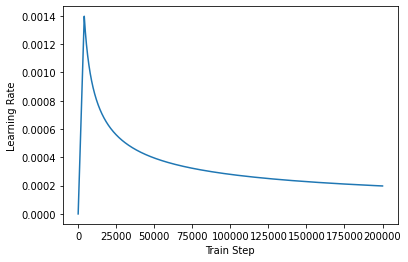

In [120]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일

In [121]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [122]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 모델 훈련

In [188]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 10s 54ms/step - loss: 0.0794 - accuracy: 0.3044
Epoch 2/20
185/185 [==============================] - 11s 59ms/step - loss: 0.0765 - accuracy: 0.3049
Epoch 3/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0687 - accuracy: 0.3070
Epoch 4/20
185/185 [==============================] - 9s 51ms/step - loss: 0.0588 - accuracy: 0.3094
Epoch 5/20
185/185 [==============================] - 10s 53ms/step - loss: 0.0511 - accuracy: 0.3110
Epoch 6/20
185/185 [==============================] - 10s 57ms/step - loss: 0.0470 - accuracy: 0.3121
Epoch 7/20
185/185 [==============================] - 10s 54ms/step - loss: 0.0417 - accuracy: 0.3132
Epoch 8/20
185/185 [==============================] - 9s 51ms/step - loss: 0.0373 - accuracy: 0.3144
Epoch 9/20
185/185 [==============================] - 9s 51ms/step - loss: 0.0346 - accuracy: 0.3152
Epoch 10/20
185/185 [==============================] - 10s 51ms/step - loss: 0.0309 -

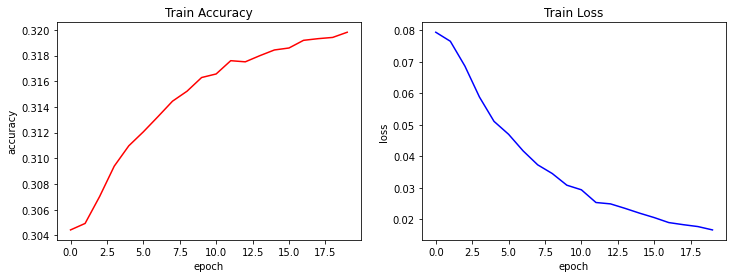

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], 'r')
ax1.set_title('Train Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')

ax2.plot(history.history['loss'], 'b')
ax2.set_title('Train Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')

plt.show()

## STEP 4. 모델 평가
---

### 1. 평가 함수 정의

#### decoder inference
예측 단계는 다음과 같은 과정을 거쳐 진행된다.
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [128]:
def decoder_inference(sentence):
    sentence = remove_punctuation(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
          START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]): break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

#### sentence generation
입력문장에 대하여 inference를 진행한 후, 어어진 정수형태의 대답을 디코드하면 문장을 반환한다.

In [131]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('🧑 입력 >>> {}'.format(sentence))
    print('🤖 출력 >>> {}'.format(predicted_sentence))

    return predicted_sentence

### 2. 모델 테스트

- 인사

In [134]:
_ = sentence_generation('안녕?')

🧑 입력 >>> 안녕?
🤖 출력 >>> 안녕하세요 .


In [135]:
_ = sentence_generation('안녕하세요?')

🧑 입력 >>> 안녕하세요?
🤖 출력 >>> 안녕하세요 .


In [136]:
_ = sentence_generation('hi!')

🧑 입력 >>> hi!
🤖 출력 >>> 마음의 정리를 해야하는 시기가 올지도 모르겠어요 .


- 일상다반사

In [165]:
_ = sentence_generation('오늘 저녁 뭐 먹을까?')
_ = sentence_generation('어제 저녁에 먹은 치킨이 정말 맛있었어.')
raw_data[raw_data['Q'].str.contains('뭐 먹을')]

🧑 입력 >>> 오늘 저녁 뭐 먹을까?
🤖 출력 >>> 맛있는 거 드세요 .
🧑 입력 >>> 어제 저녁에 먹은 치킨이 정말 맛있었어.
🤖 출력 >>> 지쳤나봐요 .


,Q,A,label
43,간식 뭐 먹을까,단짠으로 두 개 사는게 진리죠.,0
1805,뭐 먹을 거 없나,냉장고 파먹기 해보세요.,0
1806,뭐 먹을까?,좀 먹어도 괜찮아요.,0
1968,밥 뭐 먹을까,맛있는 거 드세요.,0
2955,안주 뭐 먹을까?,살 안 찌는 게 좋을 것 같아요.,0
3308,오늘 저녁 뭐 먹을까,맛있는 거 드세요.,0
3310,오늘 점심 뭐 먹을까,맛있는 거 드세요.,0
3348,오늘은 뭐 먹을까?,맛있는 거 드세요.,0
4033,저녁 메뉴 뭐 먹을까,냉장고 파먹기 해보세요.,0
4039,저녁으로 뭐 먹을까,냉장고 파먹기 해보세요.,0


In [160]:
_ = sentence_generation('내일 미용실에 갔다올거야!')
raw_data[raw_data['Q'].str.contains('미용실')]

🧑 입력 >>> 내일 미용실에 갔다올거야!
🤖 출력 >>> 예쁘게 변신하고 오세요 .


,Q,A,label
1875,미용실 가서 머리해야지,예쁘게 변신하고 오세요.,0
1876,미용실 가야지,예쁘게 변신하고 오세요.,0
1877,미용실 갔다왔는데 티가 안 나,다시 방문해보세요.,0
1878,미용실에서 너무 티 안 나게 머리를 잘라줬어,다시 방문해보세요.,0


In [162]:
_ = sentence_generation('옷이 입을게 없어ㅠㅠㅠㅠ')
_ = sentence_generation('빨래를 어제 널었는데 아직 옷이 다 안 말랐어')
raw_data[raw_data['Q'].str.contains('옷이')]

🧑 입력 >>> 옷이 입을게 없어ㅠㅠㅠㅠ
🤖 출력 >>> 이 김에 하나 장만하는 건 어떨까요 .
🧑 입력 >>> 빨래를 어제 널었는데 아직 옷이 다 안 말랐어
🤖 출력 >>> 이 김에 하나 장만하는 건 어떨까요 .


,Q,A,label
3397,옷이 다 젖었어,감기 조심 하세요.,0
10786,오늘 짝남 만나는데 옷이 없다.,이 김에 하나 장만하는 건 어떨까요.,2
10788,오늘 짝녀 만나기로 했는데 옷이 없네.,이 김에 하나 장만하는 건 어떨까요.,2


In [183]:
_ = sentence_generation('집 비밀번호 까먹었는데 어쩌지')
raw_data[raw_data['Q'].str.contains('비밀번호')]

🧑 입력 >>> 집 비밀번호 까먹었는데 어쩌지
🤖 출력 >>> 회원정보 찾기를 해보세요 .


,Q,A,label
2206,비밀번호 기억안 나,회원정보 찾기를 해보세요.,0
2207,비밀번호 까먹었다,회원정보 찾기를 해보세요.,0
2208,비밀번호 뭐였더라,회원정보 찾기를 해보세요.,0
2209,비밀번호 자꾸 바꾸래,보안상 그게 좋죠.,0
2210,비밀번호 자꾸 바꿔,보안상 그게 좋죠.,0
6552,비밀번호 뭐였더라,회원정보 찾기를 해보세요.,1


- 이별(부정)

In [184]:
_ = sentence_generation('오늘 헤어졌어요')
_ = sentence_generation('우리 헤어졌어요')
_ = sentence_generation('내 맘 알 것 같다면 옆에서 같이 울어줘요')
_ = sentence_generation('나는 안되나 봐요 역시 아닌가 봐요')
_ = sentence_generation('얼마나 더 울어야 제대로 사랑할까요')

🧑 입력 >>> 오늘 헤어졌어요
🤖 출력 >>> 많이 힘들었겠어요 .
🧑 입력 >>> 우리 헤어졌어요
🤖 출력 >>> 많이 힘들었겠어요 .
🧑 입력 >>> 내 맘 알 것 같다면 옆에서 같이 울어줘요
🤖 출력 >>> 연락하지마요 .
🧑 입력 >>> 나는 안되나 봐요 역시 아닌가 봐요
🤖 출력 >>> 네 말씀해주세요 .
🧑 입력 >>> 얼마나 더 울어야 제대로 사랑할까요
🤖 출력 >>> 천천히 지워질 거예요 .


In [187]:
raw_data[raw_data['A'].str.contains('연락하지')]

,Q,A,label
6267,매달린후 2주째 발신자제한,이별 후에 연락하지 않는 게 좋죠.,1
6430,바보같이 연락했는데 읽씹당했어,이제 바보같이 연락하지 마요.,1
6431,바보라서 참지못하고 연락했어,이제 바보같이 연락하지 마요.,1
6725,술만 마시면.,연락하지마요.,1
7274,용기내서 새해인사 했네,이제 연락하지 마세요.,1
7575,이별하고 절대 하지 말아야할 것,술 취해서 다시 연락하지 않는게 좋아요.,1
8253,짧은연애인데 미련때문에 연락을 할지말지 ㅠ.ㅠ,사랑이 아닌 미련이라면 연락하지 말아요.,1
8401,하루 겨우 참고 또 문자 보냈네.,연락하지 않는 게 서로에게 좋을 거예요.,1
8505,헤어졌는데 자꾸 연락하네,연락하지 않는 편이 좋아요.,1
8536,헤어지고 차단하는 이유는 뭘까?,연락하지 않는 게 서로에게 좋으니가요.,1


- 평가
    - 질문에 대한 답변 문장의 완성도가 이전에 진행했던 문장생성 프로젝트들에 비하여 굉장히 높은 것을 확인할 수 있었다. 
    - 생성된 답변들은 학습 데이터로 입력되었던 답변들을 재현하고 있다.

## STEP 5. 결론
---

### 프로젝트 평가
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다. 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
    - 각 단계들이 순차적으로 적절히 진행되었다.
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
    - 학습이 정상적으로 진행되었다. accuracy는 점진적으로 증가하고 loss는 감소하는것을 확인할 수 있었다.
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.
    - 챗봇이 완성도 있는 문장을 반환하지만, 답변이 적절한지는 잘 모르겠다.

### 회고
- 결과는 잘 나왔지만 정확히 어떻게 동작하지는 아직까지 잘 파악되지 않는다.
- 특히 어텐션의 개념이 잘 잡히지 않는다.
- RNN - LSTM - Attention - Transformer으로 연결되는 개념의 흐름을 한 번 재대로 정리해야 할 필요가 있음을 느꼈다.